In [28]:
%matplotlib inline

### Atenção: Rode esta linha apenas se estiver usando o Google Colab

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [29]:
import torch
from torch import nn
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets
import numpy as np

### O código da célula abaixo contém funções para efetuar a carga dos dados, treinamento teste dos modelos

In [3]:
# Download do dataset
import os 
if not os.path.exists('videodata.zip'):
    !wget https://s3-us-west-2.amazonaws.com/wehrmann/videodata.zip
    !unzip videodata.zip

/bin/sh: wget: command not found
unzip:  cannot find or open videodata.zip, videodata.zip.zip or videodata.zip.ZIP.


In [30]:
class VideoLoader(torch.utils.data.Dataset):
    
    def __init__(self, path='./videodata', data_split='train',):
        super(VideoLoader, self).__init__()
        self.data = np.load('{}/{}_videos.npy'.format(path, data_split))
        self.labels = np.load('{}/{}_labels.npy'.format(path, data_split))
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
                
        
    def __getitem__(self, index):
        video = self.data[index].transpose([0, 2, 3, 1])
        x = [self.transform(frame) for frame in video]
        x = torch.stack(x, 0)
        
        label = self.labels[index]
        return x, label
    
    def __len__(self):
        return len(self.data)
            
            
        

In [31]:
def get_loaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_loader = torch.utils.data.DataLoader(
        dataset=VideoLoader(data_split='train'),
        batch_size=batch_size, 
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=VideoLoader(data_split='test'),
        batch_size=batch_size, 
        shuffle=True
    )
    return train_loader, test_loader

def train_epoch(
        model, 
        device, 
        train_loader, 
        optimizer, 
        criterion, 
        epoch, 
        log_interval
    ):
    model.train()
    history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(
        model, 
        device, 
        criterion, 
        test_loader
    ):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy


def train(
        model,
        train_loader,
        test_loader,
        device,
        lr,
        nb_epochs=3,
        log_interval=100,
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)        
    
    return acc

def check_input(model, device):
    dummy_data = torch.zeros(5, 3, 1, 28, 28).to(device)
    dummy_pred = model(dummy_data)        
    assert dummy_pred.shape == (5, 2), '\nOutput expected: (batch_size, 10) \nOutput found   : {}'.format(dummy_pred.shape)
    print('Passed')
    return dummy_pred

def plot_instances(videos, labels, n_instances=5, n_frames=3):
    fig, axes = plt.subplots(n_instances, n_frames)
    for i, axs in enumerate(axes):
        for j, ax in enumerate(axs):
            ax.imshow(videos[i,j].squeeze(), cmap='gray')            
            ax.set_xticks([])
            ax.set_yticks([])
        ax.text(35, 15, 'Label: {} - {}'.format(labels[i], label_dict[labels[i]]), fontsize=14)

label_dict = ['Decrescente', 'Crescente']        

### Hyper-parâmetros que você pode definir

In [41]:
batch_size = 16
device_name = 'cpu'
nb_epochs = 3
log_interval = 500
lr = 2e-4

In [42]:
device = torch.device(device_name)

### Conferência dos dados

In [43]:
train_loader, test_loader = get_loaders(batch_size=batch_size)

In [44]:
print(
    'Train size: ', 
    train_loader.dataset.data.shape, 
    train_loader.dataset.labels.shape
)
print(
    'Test size : ', 
    test_loader.dataset.data.shape, 
    test_loader.dataset.labels.shape
)

Train size:  (40000, 3, 1, 28, 28) (40000,)
Test size :  (4000, 3, 1, 28, 28) (4000,)


In [45]:
videos, labels = next(iter(train_loader))
print('Instance Example: ', videos.shape, labels.shape)

Instance Example:  torch.Size([16, 3, 1, 28, 28]) torch.Size([16])


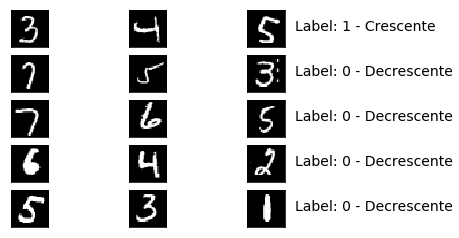

In [46]:
plot_instances(videos, labels)

## Seu trabalho começa aqui:

## 1. Crie uma rede neural, usando `nn.LSTM()` ou `nn.GRU()` para processar a dimensão temporal. 


* Utilize a rede DigitsConvNet para processar cada um dos frames. 
* Utilize uma rede recorrente da sua escolha para processar a dimensão temporal. 

In [47]:
class DigitsConvNet(nn.Module):
    def __init__(self):
        super(DigitsConvNet, self).__init__()
        self.conv_a = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv_b = nn.Conv2d(32, 64, 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_a(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv_b(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        return x

In [52]:
class VideoLSTM(nn.Module):
    def __init__(self):
        super(VideoLSTM, self).__init__()
        
        # Rede para processamento de cada frame
        self.digitscnn = DigitsConvNet()
        self.lstm = nn.LSTMCell(3136, 64)
        self.lc = nn.Linear(64, 2)
        
    def forward(self, x):
        batch, time_steps, channels, h, w = x.shape
        x_flat = x.view(batch*time_steps, channels, h, w)
        features = self.digitscnn(x_flat)
        features = features.view(batch, time_steps, -1)
    
        hidden_act = torch.zeros(batch, 64)
        cell_act = torch.zeros(batch, 64)

        for time_step in range(time_steps):
            xt = features[:, time_step, :]
            hidden_act, cell_act = self.lstm(xt, (hidden_act, cell_act))
        
        out = self.lc(hidden_act)
        return out

In [53]:
model = VideoLSTM().to(device)
dummy_pred = check_input(model, device)

Passed


In [54]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/40000 (0%)]	Loss: 0.699010
Train Epoch: 1 [8000/40000 (20%)]	Loss: 0.404399
Train Epoch: 1 [16000/40000 (40%)]	Loss: 0.075945
Train Epoch: 1 [24000/40000 (60%)]	Loss: 0.040988
Train Epoch: 1 [32000/40000 (80%)]	Loss: 0.026652

* * * Evaluating * * *
Test set: Average loss: 0.0010, Accuracy: 3985/4000 (99.62%)


* * * Training * * *
Train Epoch: 2 [0/40000 (0%)]	Loss: 0.002557
Train Epoch: 2 [8000/40000 (20%)]	Loss: 0.006963
Train Epoch: 2 [16000/40000 (40%)]	Loss: 0.003292
Train Epoch: 2 [24000/40000 (60%)]	Loss: 0.013132
Train Epoch: 2 [32000/40000 (80%)]	Loss: 0.011100

* * * Evaluating * * *
Test set: Average loss: 0.0006, Accuracy: 3989/4000 (99.72%)


* * * Training * * *
Train Epoch: 3 [0/40000 (0%)]	Loss: 0.001128
Train Epoch: 3 [8000/40000 (20%)]	Loss: 0.015682
Train Epoch: 3 [16000/40000 (40%)]	Loss: 0.001729
Train Epoch: 3 [24000/40000 (60%)]	Loss: 0.000194
Train Epoch: 3 [32000/40000 (80%)]	Loss: 0.001001

* * * Evaluating * * *
Test s

## 2. Atualize sua rede de classificação de vídeos usando uma Rede Recorrente Bidirecional (`nn.LSTM(bidirectional=True)`, `nn.GRU(bidirectional=True`))

In [ ]:
class BiRNN(nn.Module):
    def __init__():
        super(BiRNN, self).__init__()
        self.digitscnn = DigitsConvNet()
        self.lstm = nn.GRU(3136, 64, bidirectional = True)
        self.lc = nn.Linear(64, 2)

    def forward(self, x):
        
        return out

In [ ]:
model = BiRNN().to(device)
print(model)

pred = model(torch.zeros(5, 3, 1, 28, 28))
print(pred.shape)

In [ ]:
dummy_pred = check_input(model, device)

In [ ]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))

## 3. Implemente uma rede neural para classificação de vídeos usando um *global average pooling* para processar a dimensão temporal

**OBS: Treine esta rede por apenas 1 época!**

Sua rede deve conter uma rede convolucional para processar cada *frame* do vídeo. O processamnto da dimensão temporal deverá ser feito através de um *global average pooling*. 

In [ ]:
class GlobalPoolNet(nn.Module):
    def __init__(self):
        super(GlobalPoolNet, self).__init__()
        # Rede para processamento de cada frame
        self.digitscnn = DigitsConvNet()   
    
    def forward(self, x):
        
        return out

### 3.1 Verifique se a saída do seu modelo está correta

In [ ]:
model = GlobalPoolNet().to(device)
print(model)

pred = model(torch.zeros(5, 3, 1, 28, 28).to(device))

In [ ]:
dummy_pred = check_input(model, device)

### 3.2 Treine seu modelo por uma (1) época

In [ ]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))

## 4. Implemente o processamento da dimensão temporal utilizando uma camada de convolução 


In [ ]:
class VideoConvNet(nn.Module):
    def __init__():
        super(VideoConvNet, self).__init__()            

    def forward(self, x):        
        return out

In [ ]:
model = VideoLSTM().to(device)
print(model)

pred = model(torch.zeros(5, 3, 1, 28, 28))
print(pred.shape)

In [ ]:
dummy_pred = check_input(model, device)

In [ ]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))

## 5. Implemente uma rede de classificação de vídeos utilizando convoluções 3D (`nn.Conv3d()`)

In [ ]:
class Video3DConvNet(nn.Module):
    def __init__():
        super(Video3DConvNet, self).__init__()            

    def forward(self, x):        
        return out

In [ ]:
model = Video3DConvNet().to(device)
print(model)

pred = model(torch.zeros(5, 3, 1, 28, 28))
print(pred.shape)

In [ ]:
dummy_pred = check_input(model, device)

In [ ]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))